# Evaluation of 1 regression vs. classification + regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import pandas as pd
import plotly as ply
import seaborn as sns
from matbench.core.analysis import Analysis

%matplotlib inline
ply.offline.init_notebook_mode(connected=True)
sns.set()
sns.set_context("poster", font_scale=1.1)

/Users/alirezafaghaninia/Documents/py3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## All inputs:

In [2]:
# inputs
TARGET = ('Input Data', 'gap expt')
CALC_DIR = 'run_data'
SEED = 53
EXCLUDED_FEATURIZERS = [
    'CohesiveEnergy', 
#                         'AtomicPackingEf/ficiency',
                        'PartialRadialDistributionFunction',
                        'RadialDistributionFunction',
                        'CoulombMatrix',
                        'SineCoulombMatrix',
                        'OrbitalFieldMatrix',
#                         'MinimumRela/tiveDistances',
                        'ElectronicRadialDistributionFunction',
#     'YangSolidSolution',
'Miedema']
np.random.seed(SEED)
NFOLD = 5 # for cross-validation
N_JOBS = 6

## Read the data only containing chemical formula and experimentally measured band gap

In [3]:
from matminer.datasets.convenience_loaders import load_expt_gap
# df_init = pd.read_csv('../data/sources/gap_expt.csv')
df_init = load_expt_gap()
df_init.head()

,formula,gap expt
0,Hg0.7Cd0.3Te,0.35
1,CuBr,3.08
2,LuP,1.30
3,Cu3SbSe4,0.40
4,ZnO,3.44


## Feature generation: formula -> more than 320 features

In [5]:
df_featurized = pd.read_pickle(os.path.join(CALC_DIR, 'df_featurized.pickle'))

## Preprocessing (drop columns w/ more than 10% nulls + one-hot encoding of str columns)

In [6]:
from matbench.core.preprocess import Preprocess
from skrebate import ReliefF
prep = Preprocess()

df = prep.handle_na(df_featurized, max_na_frac=0.05, na_method='drop')
df = prep.prune_correlated_features(df, target_key=TARGET)
df = pd.get_dummies(df)

2018-09-26 18:37:35 INFO     Before handling na: 6354 samples, 237 features
2018-09-26 18:37:36 INFO     These 65 features were removed as they had more than 5.0% missing values:
{('CationProperty', 'mean total_ioniz of cations'), ('CationProperty', 'range xtal_field_split of cations'), ('CationProperty', 'maximum magn_moment of cations'), ('CationProperty', 'range sat_magn of cations'), ('ElementProperty', 'maximum coefficient_of_linear_thermal_expansion'), ('YangSolidSolution', 'Yang omega'), ('CationProperty', 'minimum sat_magn of cations'), ('CationProperty', 'mean so_coupling of cations'), ('CationProperty', 'range total_ioniz of cations'), ('CationProperty', 'mean sat_magn of cations'), ('CationProperty', 'maximum xtal_field_split of cations'), ('CationProperty', 'maximum total_ioniz of cations'), ('ElementProperty', 'range velocity_of_sound'), ('ElementProperty', 'mean bulk_modulus'), ('OxidationStates', 'minimum oxidation state'), ('ElementProperty', 'range electrical_resistivi

## Initial stratified split (unbalanced, many metals (target=0))

In [48]:
from sklearn.model_selection import train_test_split
X_train0, X_test0, y_train0, y_test0 = train_test_split(df.drop(TARGET, axis=1), df[TARGET], test_size=0.2, random_state=SEED)

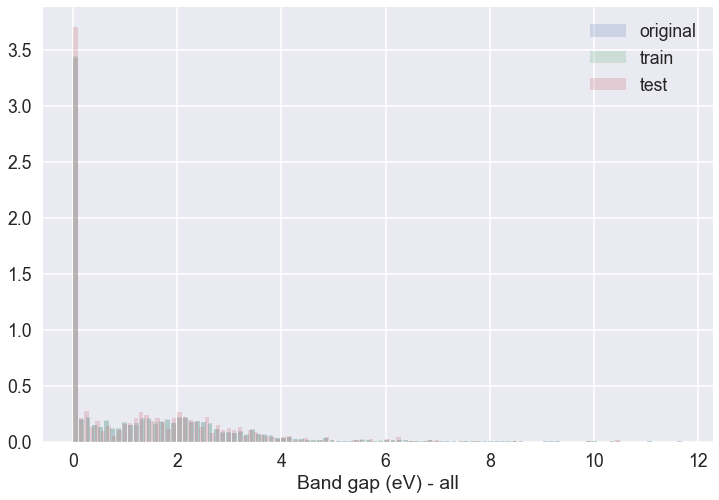

In [49]:
ALPHA = .2
RWIDTH = 0.8
BINS = 100
plt.figure(figsize=(12, 8))
plt.hist(df[TARGET], bins=BINS, density=True, alpha=ALPHA, label='original', rwidth=RWIDTH)
plt.hist(y_train0, bins=BINS, density=True, alpha=ALPHA, label='train', rwidth=RWIDTH)
plt.hist(y_test0, bins=BINS,  density=True, alpha=ALPHA, label='test', rwidth=RWIDTH)
plt.xlabel('Band gap (eV) - all');
plt.legend();
